In [1]:
using Statistics, Random, DelimitedFiles, LinearAlgebra, BenchmarkTools, Plots, Revise, QuadGK, Polyester, Enzyme, PyPlot
using ForwardDiff, DifferentialEquations, DataFrames, DiffEqSensitivity, BioSimulator, Sundials, LaTeXStrings, NumericIO
using ForwardDiff: Chunk, JacobianConfig
using AnalyticSensitivity

In [2]:
ASPkg = AnalyticSensitivity
SAVE_FIGURES = true
pyplot()
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "axes.labelweight" => "normal",
        "axes.labelsize" => 13,
        "xtick.labelsize" => 11,
        "ytick.labelsize" => 11,
        "legend.fontsize" => 11,
)
merge!(rcParams, font0)
versioninfo()

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)


# Figure 1

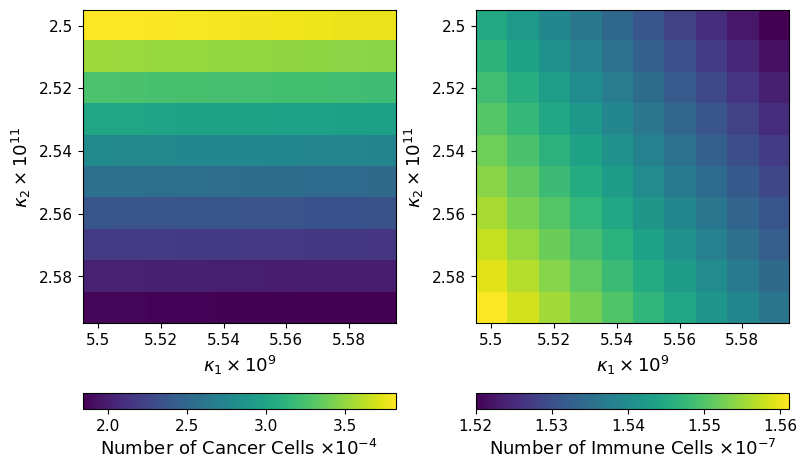

In [200]:
iters = 10
t = 1000.0
tspan = (0.0, t)
k1 = zeros(iters)
k2 = zeros(iters)
X = zeros(iters, iters)
Y = zeros(iters, iters)
x0 = [1.25e4, 6.25e2] # initial values
for i = 1:iters
    k1[i] = 5.5e-9 + (i - 1) * (1.0e-11)
    for j = 1:iters
        k2[j] = 2.5e-11 + (j - 1) * (1.0e-13)
        p = [k1[i], k2[j], 1.0e-6, 6.0e-2, 1.0e9]
        prob = ODEProblem(CARRGO, x0, tspan, p)
        sol = solve(prob)
        X[i,j]= sol(tspan[2])[1]
        Y[i,j]= sol(tspan[2])[2]
    end
end
X = X./10^4
Y = Y./10^7
k1 = round.(k1.*10^9, digits = 3)
k2 = round.(k2.*10^(11), digits = 3)
PyPlot.figure(figsize=(8.1, 5))
PyPlot.subplot(1,2,1)
PyPlot.imshow(X')
xlabel(L"\kappa_1 \times 10^9")
ylabel(L"\kappa_2 \times 10^{11}")
PyPlot.xticks([0,2,4,6,8], [k1[1],k1[3],k1[5],k1[7],k1[9]])
PyPlot.yticks([0,2,4,6,8], [k2[1],k2[3],k2[5],k2[7],k2[9]])
PyPlot.colorbar(orientation="horizontal", label=L"Number of Cancer Cells $\times 10^{-4}$")
PyPlot.subplot(1,2,2)
PyPlot.imshow(Y')
xlabel(L"\kappa_1 \times 10^9")
ylabel(L"\kappa_2 \times 10^{11}")
PyPlot.xticks([0,2,4,6,8], [k1[1],k1[3],k1[5],k1[7],k1[9]])
PyPlot.yticks([0,2,4,6,8], [k2[1],k2[3],k2[5],k2[7],k2[9]])
PyPlot.colorbar(orientation="horizontal", label=L"Number of Immune Cells $\times 10^{-7}$")
PyPlot.tight_layout()
PyPlot.show()
SAVE_FIGURES && PyPlot.savefig("Figure1");

# Figure 2

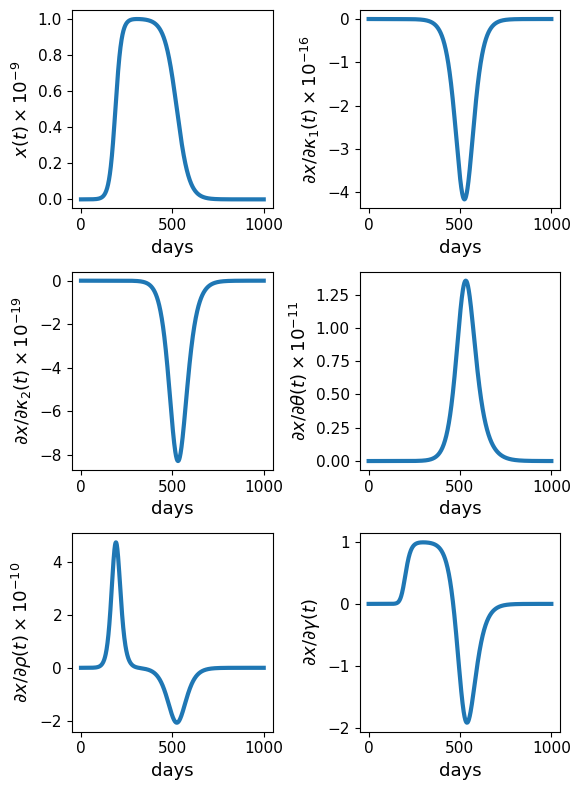

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [163]:
p = [6.0e-9, 3.0e-11, 1.0e-6, 6.0e-2, 1.0e9]; # parameters
x0 = [1.25e4, 6.25e2]; # initial values
(d, tspan) = (1.0e-12, (0.0,1000.0)); # 1000 days
solution = analytic_method(Order1(), CARRGO, x0, p, tspan, d, alg=Vern9(), abstol=1e-12, reltol=1e-12); # find solution and partials
PyPlot.figure(figsize=(6,8))
PyPlot.subplot(3,2,1)
PyPlot.plot(solution[1][:, 1].*1e-9, linewidth = 3)
xlabel("days")
ylabel(L"x(t) \times 10^{-9}")
PyPlot.subplot(3,2,2)
PyPlot.plot(solution[1][:, 2].*1e-16, linewidth = 3)
xlabel("days")
ylabel(L"\partial x / \partial \kappa_1(t) \times 10^{-16}")
PyPlot.subplot(3,2,3)
PyPlot.plot(solution[1][:, 3].*10^(-19), linewidth = 3)
xlabel("days")
ylabel(L"\partial x / \partial \kappa_2(t) \times 10^{-19}")
PyPlot.subplot(3,2,4)
PyPlot.plot(solution[1][:, 4]*1e-11, linewidth = 3)
xlabel("days")
ylabel(L"\partial x / \partial \theta (t) \times 10^{-11}")
PyPlot.subplot(3,2,5)
PyPlot.plot(solution[1][:, 5].*1e-10, linewidth = 3)
xlabel("days")
ylabel(L"\partial x / \partial \rho (t) \times 10^{-10}")
PyPlot.subplot(3,2,6)
PyPlot.plot(solution[1][:, 6], linewidth = 3)
xlabel("days")
ylabel(L"\partial x / \partial \gamma (t)")
PyPlot.tight_layout()
PyPlot.show()
SAVE_FIGURES && PyPlot.savefig("Figure2");

# Figure 3

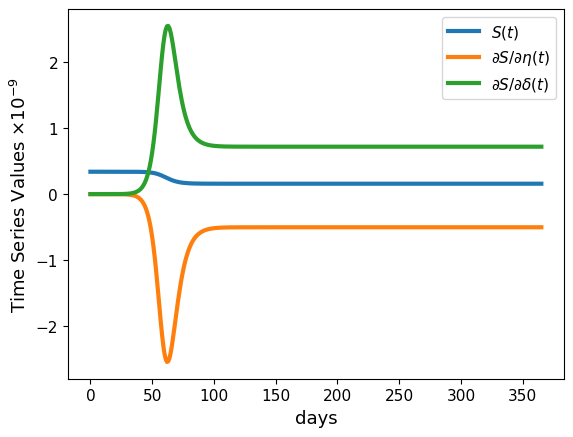

In [26]:
#data for Figure 3
p1 = (0.48 - 0.0012) / 2 + 0.48
p2 = (0.588 - 0.417) / 2 + 0.417
(S0,I0) = (3.4e8, 100.0)
p = [p1, p2, S0+I0]; # parameters
x0 = [S0, I0, 0.0]; # initial values
(d, tspan) = (1.0e-12, (0.0, 365.0)) # 365 days
solution = analytic_method(Order1(), SIR, x0, p, tspan, d)
PyPlot.plot(solution[1][:, 1:3].*1e-9, linewidth=3)
legend([L"S(t)",L"\partial S / \partial \eta (t)",L"\partial S / \partial \delta(t)"])
xlabel("days")
ylabel(L"Time Series Values $\times 10^{-9}$")
SAVE_FIGURES && PyPlot.savefig("Figure3");

# Figure 4

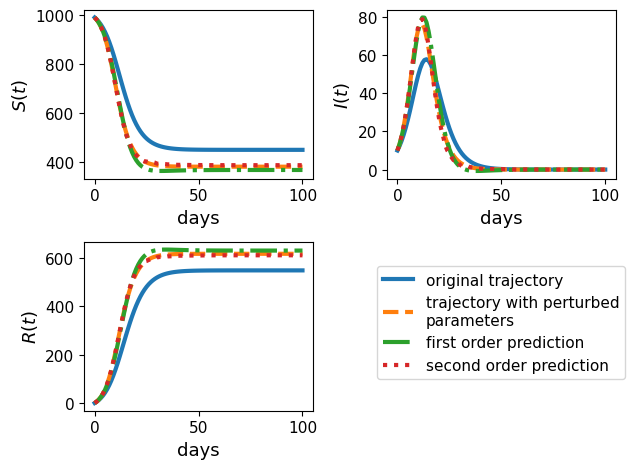

Euclidean distance between first order prediction and actual trajectory = 154.42606228988498
Euclidean distance between second order prediction and actual trajectory = 60.36954714059782
Euclidean distance between first order prediction and actual trajectory = 25.38960516625814
Euclidean distance between second order prediction and actual trajectory = 11.310324642512345
Euclidean distance between first order prediction and actual trajectory = 154.0310134710477
Euclidean distance between second order prediction and actual trajectory = 60.61416889156976


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [27]:
t = 100
function differential(f::Function, p, d)
    fvalue = real(f(p)) # function value
    df = zeros(length(fvalue), 0) # empty differential
    for i = 1:length(p)
        p_i = p[i]
        p[i] = p_i + d * im # perturb parameter
        fi = f(p) # compute perturbed function value
        p[i] = p_i # reset parameter to p_i + 0*i
        df  = [df imag(fi) ./ d] # concatenate ith partial
    end
    return (fvalue, df) # return the differential
end
function hessian_2(f::Function, p, d)
    n = t+1
    d2f = zeros(length(p), length(p), n) # hessian
    dp = d * (1.0 + 1.0 * im) / sqrt(2) # perturbation
    for i = 1:length(p) # compute diagonal entries of d2f
        p_i = p[i]
        p[i] = p_i + dp
        fplus = f(p)[1]
        p[i] = p_i - dp
        fminus = f(p)[1]
        p[i] = p_i
        d2f[i, i,:]  = imag(fplus + fminus) / d^2
    end
    for j = 2:length(p) # compute off diagonal entries of d2f
        for k = 1:(j - 1)
            (p_j, p_k) = (p[j], p[k])
            (p[j], p[k]) = (p_j + dp, p_k + dp)
            fplus = f(p)[1]
            (p[j], p[k]) = (p_j - dp, p_k - dp)
            fminus = f(p)[1]
            (p[j], p[k]) = (p_j, p_k)
            d2f[j, k,:]  = imag(fplus + fminus) / d^2
            d2f[j, k,:] = (d2f[j, k,:] - d2f[j, j,:] - d2f[k, k,:]) / 2
            d2f[k, j,:] = d2f[j, k,:]
        end
    end
    return d2f
end
function solve_SIR_S(p)
    epsilon1 = 1e-12
    epsilon2 = 1e-6
    N = 1000
    n = 10
    x0 = complex([N - n, n, 0.0])
    params = complex([p[1], p[2], N])
    tspan = (0.0,t)
    ODE = SIR
    problem = ODEProblem(ODE, x0, tspan, params)
    sol = solve(problem, saveat = 1.0)
    solution = [sol[1, :]]
    return solution
end
function solve_SIR_I(p)
    epsilon1 = 1e-12
    epsilon2 = 1e-6
    N = 1000
    n = 10
    x0 = complex([N - n, n, 0.0])
    params = complex([p[1], p[2], N])
    tspan = (0.0,t)
    ODE = SIR
    problem = ODEProblem(ODE, x0, tspan, params)
    sol = solve(problem, saveat = 1.0)
    solution = [sol[2, :]]
    return solution
end
function solve_SIR_R(p)
    epsilon1 = 1e-12
    epsilon2 = 1e-6
    N = 1000
    n = 10
    x0 = complex([N - n, n, 0.0])
    params = complex([p[1], p[2], N])
    tspan = (0.0,t)
    ODE = SIR
    problem = ODEProblem(ODE, x0, tspan, params)
    sol = solve(problem, saveat = 1.0)
    solution = [sol[3, :]]
    return solution
end
#=
The pseudorandom stream for MersenneTwister is liable to change across Julia versions.
Use a local RNG with seed = 1903. Should make results reproducible for a given Julia version.
=#
p1 = (0.48 - 0.0012) / 2 + 0.48
p2 = (0.588 - 0.417) / 2 + 0.417
RNG = MersenneTwister(1903)
p = [p1, p2]
change = (rand(RNG, length(p)) .- .5) .* (.25/.5)
h = change .*p
p_new = p + h

function predict_trajectory(f, p, h, t, p_new)
    (fx, dfx) = differential(f, complex(p), 1e-12)
    first = fx[1] + [dfx[1] dfx[2]] * h
    d2f = hessian_2(f, complex(p), 1e-6)
    second = zeros(t+1)
    for i = 1:(t+1)
        second[i] = first[i] + .5 * transpose(h) * d2f[:,:,i]*h
    end
    actual = real(f(p_new))[1]
    original = real(f(p))[1]
    println("Euclidean distance between first order prediction and actual trajectory = ", sqrt(sum((actual - first).^2)))
    println("Euclidean distance between second order prediction and actual trajectory = ", sqrt(sum((actual - second).^2)))
    return (original, actual, first, second)
end

(original, actual, first, second) = predict_trajectory(solve_SIR_S, p, h, t, p_new)
PyPlot.subplot(2,2,1)
PyPlot.plot(original, linewidth=3)
PyPlot.plot(actual, linewidth=3, linestyle="--")
PyPlot.plot(first, linewidth=3, linestyle="-.")
PyPlot.plot(second, linewidth=3, linestyle=":")
xlabel("days")
ylabel(L"S(t)")
(original, actual, first, second) = predict_trajectory(solve_SIR_I, p, h, t, p_new)
PyPlot.subplot(2,2,2)
PyPlot.plot(original, linewidth=3)
PyPlot.plot(actual, linewidth=3, linestyle="--")
PyPlot.plot(first, linewidth=3, linestyle="-.")
PyPlot.plot(second, linewidth=3, linestyle=":")
xlabel("days")
ylabel(L"I(t)")
(original, actual, first, second) = predict_trajectory(solve_SIR_R, p, h, t, p_new)
PyPlot.subplot(2,2,3)
PyPlot.plot(original, linewidth=3)
PyPlot.plot(actual, linewidth=3, linestyle="--")
PyPlot.plot(first, linewidth=3, linestyle="-.")
PyPlot.plot(second, linewidth=3, linestyle=":")
xlabel("days")
ylabel(L"R(t)")
PyPlot.tight_layout()
legend(["original trajectory",join(["trajectory with perturbed", "parameters"], '\n'),"first order prediction", "second order prediction"],bbox_to_anchor=(2.4, 0.9))
SAVE_FIGURES && PyPlot.savefig("Figure4");
PyPlot.show()

# Figure 5

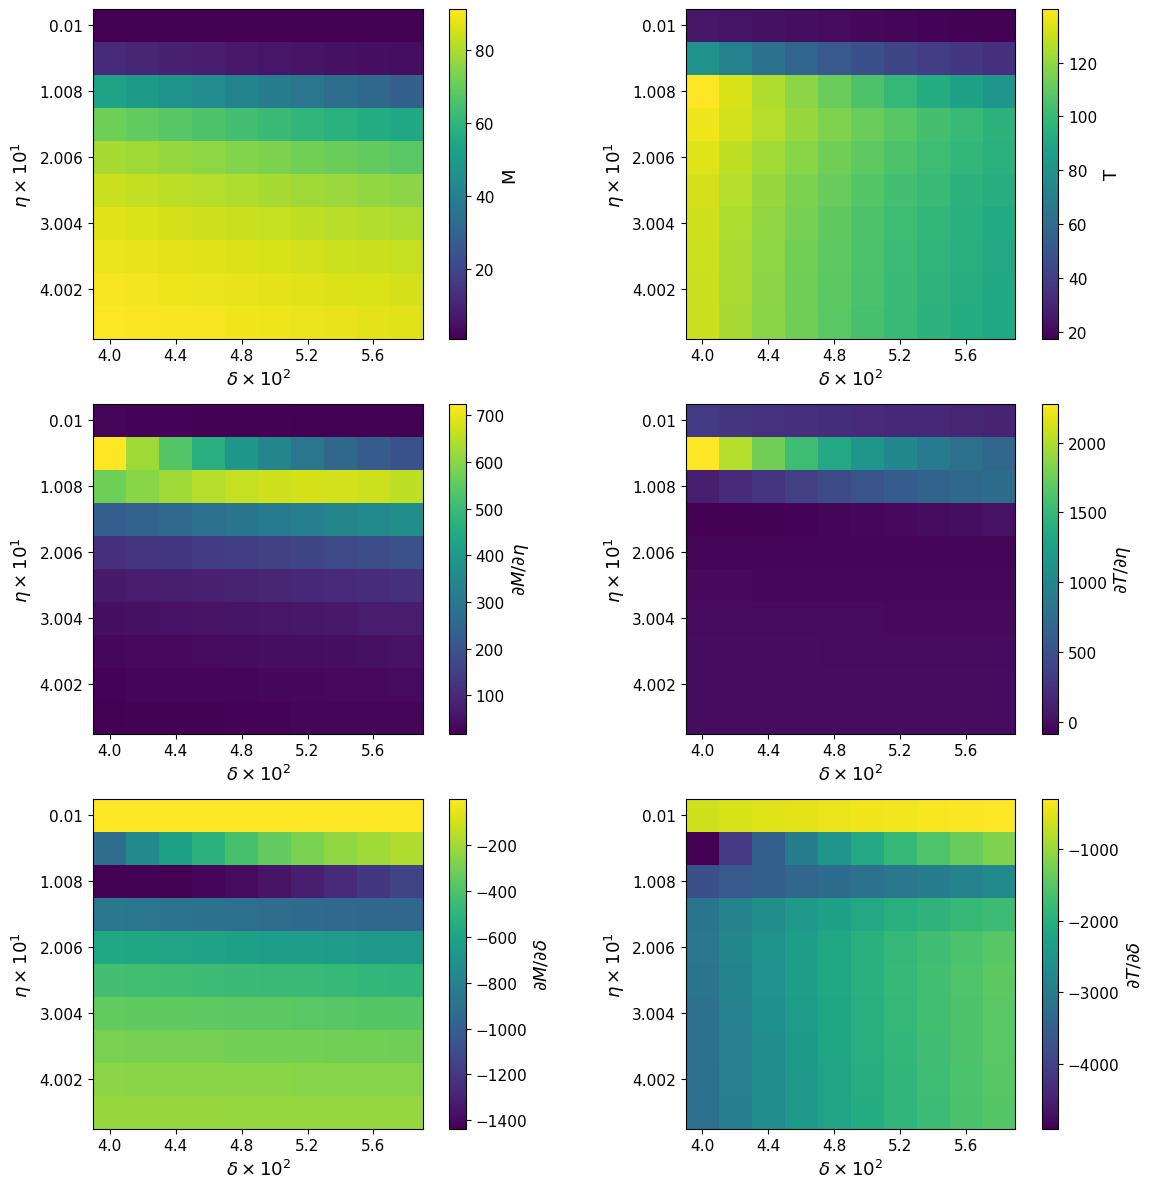

In [201]:
N=100
n=Int(floor(N/100))
iters=10
delta=zeros(iters)
eta=zeros(iters)
m=zeros(iters,iters)
dmdd=zeros(iters,iters)
dmde=zeros(iters,iters)
t=zeros(iters,iters)
dtdd=zeros(iters,iters)
dtde=zeros(iters,iters)
for i in 1:iters
    delta[i]=4e-2 + (i-1)*(6e-2 - 4e-2)/iters #evaluate on increments in the range 0.04 to 0.06
    for j in 1:iters
        eta[j]=1e-3 + (j-1)*(5e-1 - 1e-3)/iters #evaluate on increments in the range 0.001 to 0.5
        m[i,j]=ASPkg.meannumber(N,delta[i],eta[j])[n+1]
        dmde[i,j]=ASPkg.dm_deta(N,delta[i],eta[j])[n+1]
        dmdd[i,j]=ASPkg.dm_ddelta(N,delta[i],eta[j])[n+1]
        t[i,j]=ASPkg.meantime(N,delta[i],eta[j])[n+1]
        dtde[i,j]=ASPkg.dt_deta(N,delta[i],eta[j])[n+1]
        dtdd[i,j]=ASPkg.dt_ddelta(N,delta[i],eta[j])[n+1]
    end
end
delta = round.(delta.*10^2, digits = 3)
eta = round.(eta.*10, digits = 3)

PyPlot.figure(figsize=(12, 12))
PyPlot.subplot(3,2,1)
PyPlot.imshow(m')
xlabel(L"\delta \times 10^2")
ylabel(L"\eta \times 10^1")
PyPlot.xticks([0,2,4,6,8], [delta[1],delta[3],delta[5],delta[7],delta[9]])
PyPlot.yticks([0,2,4,6,8], [eta[1],eta[3],eta[5],eta[7],eta[9]])
PyPlot.colorbar(orientation="vertical", label="M")
PyPlot.subplot(3,2,2)
PyPlot.imshow(t')
xlabel(L"\delta \times 10^2")
ylabel(L"\eta \times 10^1")
PyPlot.xticks([0,2,4,6,8], [delta[1],delta[3],delta[5],delta[7],delta[9]])
PyPlot.yticks([0,2,4,6,8], [eta[1],eta[3],eta[5],eta[7],eta[9]])
PyPlot.colorbar(label="T")
PyPlot.subplot(3,2,3)
PyPlot.imshow(dmde')
xlabel(L"\delta \times 10^2")
ylabel(L"\eta \times 10^1")
PyPlot.xticks([0,2,4,6,8], [delta[1],delta[3],delta[5],delta[7],delta[9]])
PyPlot.yticks([0,2,4,6,8], [eta[1],eta[3],eta[5],eta[7],eta[9]])
PyPlot.colorbar(label=L"\partial M / \partial \eta")
PyPlot.subplot(3,2,4)
PyPlot.imshow(dtde')
xlabel(L"\delta \times 10^2")
ylabel(L"\eta \times 10^1")
PyPlot.xticks([0,2,4,6,8], [delta[1],delta[3],delta[5],delta[7],delta[9]])
PyPlot.yticks([0,2,4,6,8], [eta[1],eta[3],eta[5],eta[7],eta[9]])
PyPlot.colorbar(label=L"\partial T / \partial \eta")
PyPlot.subplot(3,2,5)
PyPlot.imshow(dmdd')
xlabel(L"\delta \times 10^2")
ylabel(L"\eta \times 10^1")
PyPlot.xticks([0,2,4,6,8], [delta[1],delta[3],delta[5],delta[7],delta[9]])
PyPlot.yticks([0,2,4,6,8], [eta[1],eta[3],eta[5],eta[7],eta[9]])
PyPlot.colorbar(label=L"\partial M / \partial \delta")
PyPlot.subplot(3,2,6)
PyPlot.imshow(dtdd')
xlabel(L"\delta \times 10^2")
ylabel(L"\eta \times 10^1")
PyPlot.xticks([0,2,4,6,8], [delta[1],delta[3],delta[5],delta[7],delta[9]])
PyPlot.yticks([0,2,4,6,8], [eta[1],eta[3],eta[5],eta[7],eta[9]])
PyPlot.colorbar(label=L"\partial T / \partial \delta")

PyPlot.tight_layout()
PyPlot.show()
SAVE_FIGURES && PyPlot.savefig("Figure5");

# Table 1

In [80]:
#=Please note that due to the random nature of stochastic simulation, running this cell may not result in exactly the same
simulated values as appears in the manuscript.=#

#model parameters we could change
N = 34000
t = 1000
numSim = 100
n = 1

# model parameters to keep simulation consistent
eta = (0.48 - 0.0012) / 2 + 0.48
delta = (0.588 - 0.417) / 2 + 0.417
extinctionTimes = zeros(numSim)
numberInfected = zeros(numSim)
i = 1
numSkipped = 0

network = Network("SIR")
network <= Species("S", N - n)
network <= Species("I", n)
network <= Species("R", 0)
network <= BioSimulator.Reaction("infection", eta/N, "S + I --> I + I")
network <= BioSimulator.Reaction("immunity", delta, "I --> R")
state, model = parse_model(network::Network)

Random.seed!(1903) # BioSimulator uses GLOBAL_RNG; this makes result here semi-reproducible
while i <= numSim
    trajectory = simulate(state, model, BioSimulator.SortingDirect(), tfinal = t, save_points = 0:t)
    if trajectory[t][2] > 0
        numSkipped += 1
    else
        numberInfected[i] = trajectory[t + 1][3]
        j = 1
        while trajectory[j][2] > 0
            j = j+1
        end
        extinctionTimes[i] = j
        i += 1
    end
end

println(numSkipped, " trajectories did not go extinct by tEnd")

#statistics for mean number
std_m = Statistics.std(numberInfected)
mean_m = mean(numberInfected)
ste_m = std_m / sqrt(numSim)
calc_m = ASPkg.meannumber(N, delta, eta)[n+1]
println("Mean number ever infected: ", mean_m)
println("Standard error for number: ", ste_m)
println("Range of one standard error for number: [", mean_m - ste_m, ", ", mean_m + ste_m, "]")
println("Calculated mean number: ", calc_m)

#statistics for mean time
std_t = Statistics.std(extinctionTimes)
mean_t = mean(extinctionTimes)
ste_t = std_t / sqrt(numSim)
calc_t = ASPkg.meantime(N, delta, eta)[n+1]
println("Mean time to extinction: ", mean_t)
println("Standard error for time: ", ste_t)
println("Range of one standard error for time: [", mean_t - ste_t, ", ", mean_t + ste_t, "]")
println("Calculated mean time: ", calc_t)

0 trajectories did not go extinct by tEnd
Mean number ever infected: 7970.94
Standard error for number: 903.802001627267
Range of one standard error for number: [7067.137998372733, 8874.742001627266]
Calculated mean number: 5484.308631235595
Mean time to extinction: 40.85
Standard error for time: 4.302322018105427
Range of one standard error for time: [36.54767798189457, 45.15232201810543]
Calculated mean time: 27.924217060088612


# Figure 6

In [3]:
function convergence(system, x0, params, t_end, stepsize, endtol)
    ODE = DiffEqBase.ODEFunction(system)
    tspan = (0.0, t_end)
    epsilon1=eps(Float64)
    epsilon2 = sqrt(epsilon1)
    tols_x = collect(2:endtol)
    tols = 10.0 .^.-tols_x
    y = zeros(3, length(tols_x))

    for i in 1:length(tols_x)
        kwargs = (alg=Rodas4(autodiff=false), abstol=tols[i], reltol=tols[i])
        y[1, i] = DES_endpoint(Order1(), ODE, x0, params, tspan, 1, 1, stepsize; kwargs...)
        y[2, i] = FD(Order1(), ODE, x0, params, tspan; kwargs...)[1][t_end+1,2]
        y[3, i] = analytic_method(Order1(), ODE, x0, params, tspan, epsilon1; kwargs...)[1][t_end+1,2]
    end
    return (tols_x, y)
end

function DES_endpoint(::Order1, ODE::Function, x0, params, tspan, xvar, p, stepsize; alg=nothing, kwargs...)
    problem = ODEProblem(ODE, x0, tspan, params)
    sensealg = QuadratureAdjoint(autojacvec=EnzymeVJP())
    tend = tspan[2]
    
    # this has extra arguments; dg is parameterized by xvar and s
    function dg(out,u,p,t,i,xvar,s)
      fill!(out, 0) # this assigns values to the existing object
      if t == s
        out[xvar] = -1
      end
      nothing
    end
    ts = 0:stepsize:tend
    sol = solve(problem, alg; kwargs...)

    s = tend
    du0, dp = adjoint_sensitivities(sol, alg, (out,u,p,tend,i) -> dg(out,u,p,tend,i,xvar,s), ts; sensealg=sensealg, kwargs...)
    return dp[p]
end

DES_endpoint (generic function with 1 method)

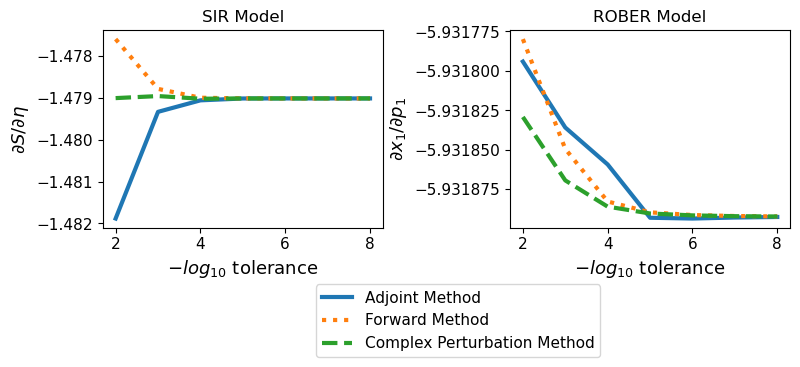

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [10]:
system = SIR
N = 3.4e8
n = 100
x0s = [N - n, n, 0.0]
params = [0.7194, 0.5025, N]
t_end = 1000
(xs, ys) = convergence(system, x0s, params, t_end, 1.0, 8)

system = ROBER
x0r = [1.0, 0.0, 0.0]
params = [0.04,3e7,1e4]
t_end = 1000
    
(xr, yr) = convergence(system, x0r, params, t_end, 0.1, 8)

PyPlot.figure(figsize=(8.1, 3))
PyPlot.subplot(1,2,1)
PyPlot.plot(xs, ys[1,:]./x0s[1], linewidth=3)
PyPlot.plot(xs, ys[2,:]./x0s[1], linewidth=3, linestyle=":")
PyPlot.plot(xs, ys[3,:]./x0s[1], linewidth=3, linestyle="--")
xlabel(L"$-log_{10}$ tolerance")
ylabel(L"\partial S / \partial \eta")
title("SIR Model")
PyPlot.subplot(1,2,2)
PyPlot.plot(xr, yr[1,:]./x0r[1], linewidth=3)
PyPlot.plot(xr, yr[2,:]./x0r[1], linewidth=3, linestyle=":")
PyPlot.plot(xr, yr[3,:]./x0r[1], linewidth=3, linestyle="--")
ax=gca()
ax[:ticklabel_format](useOffset=false)
xlabel(L"$-log_{10}$ tolerance")
ylabel(L"\partial x_1 / \partial p_1")
title("ROBER Model")
PyPlot.tight_layout()
legend(["Adjoint Method", "Forward Method", "Complex Perturbation Method"],bbox_to_anchor=(0.35, -0.25))
SAVE_FIGURES && PyPlot.savefig("Figure6", bbox_inches="tight");
PyPlot.show()

# Figure 7

In [3]:
function time_v_accuracy(system, x0, params, t_end, mintol, stepsize = 1.0)
    ODE = DiffEqBase.ODEFunction(system)
    tspan = (0.0, t_end)
    epsilon1 = eps(Float64)
    kwargs = (alg=Rodas4(autodiff=false), abstol=10^(-1*mintol), reltol=10^(-1*mintol))
    standards2 = FD(Order1(), ODE, x0, params, tspan; kwargs...)
    standards3 = analytic_method(Order1(), ODE, x0, params, tspan, epsilon1; kwargs...)
    tols_x = collect(2:Integer(mintol))
    tols = 10.0 .^.-tols_x
    errors = zeros(3, length(tols))
    time = zeros(3, length(tols))
    for i in 1:length(tols)
        kwargs = (alg=Rodas4(autodiff=false), abstol=tols[i], reltol=tols[i])
        compare2 = FD(Order1(), ODE, x0, params, tspan; kwargs...)
        compare3 = analytic_method(Order1(), ODE, x0, params, tspan, epsilon1; kwargs...)
        for compartment in 1:length(x0)
            for param in 1:length(params)
                errors[2,i] += ASPkg.euclidean_dist(standards2[compartment][:,1+param], compare2[compartment][:, 1+param])
                errors[3,i] += ASPkg.euclidean_dist(standards3[compartment][:,1+param], compare3[compartment][:, 1+param])
            end
        end
        time[2,i] = median(@benchmark FD(Order1(), $ODE, $x0, $params, $tspan; $kwargs...)).time
        time[3,i] = median(@benchmark analytic_method(Order1(), $ODE, $x0, $params, $tspan, $epsilon1; $kwargs...)).time
    end
    return (tols_x, errors, time)
end

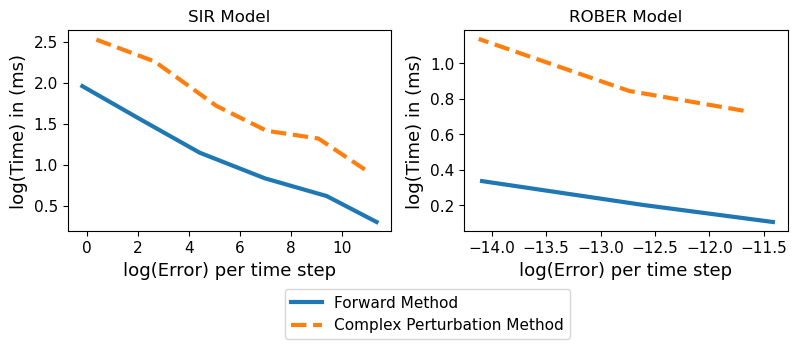

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [3]:
system = SIR
N = 3.4e8
n = 100
x0 = [N - n, n, 0.0]
params = [0.7194, 0.5025, N]
t_end = 1000
#(tols, error_s, time_s) = time_v_accuracy(system, x0, params, t_end, 8.0)

system = ROBER
x0 = [1.0, 0.0, 0.0]
params = [0.04,3e7,1e4]
t_end = 1000
 
#(tols, error_r, time_r) = time_v_accuracy(system, x0, params, t_end, 5.0, .01)

time_s = [1.3532e6 1.8565e6 2.3065e6 3.1519e6 4.7592e6 7.0979e6 1.45244e7; 2.5665e6 3.74425e6 4.12035e6 5.5786e6 9.5919e6 1.26272e7 2.1497e7]
error_s = [8.5091e7 1.20537e7 1.06374e6 83081.3 7894.69 838.057 0.0; 5.36511e7 8.71942e6 1.14017e6 1.59988e5 14205.5 1344.8 0.0]
time_r = [1.1114e6 1.223e6 1.39945e6 1.62045e6; 2.08065e6 2.3251e6 3.1183e6 2.8739e6]
error_r = [0.0110219 0.00335847 0.000760518 0.0; 0.0084121 0.00294516 0.00073721 0.0]

PyPlot.figure(figsize=(8.1, 3))
PyPlot.subplot(1,2,1)
PyPlot.plot(log.(error_s[1,:].*1e-3), log.(time_s[1,:].*1e-6), linewidth=3)
PyPlot.plot(log.(error_s[2,:].*1e-3), log.(time_s[2,:].*1e-6), linewidth=3, linestyle="--")
xlabel("log(Error) per time step")
ylabel("log(Time) in (ms)")
title("SIR Model")
PyPlot.subplot(1,2,2)
PyPlot.plot(log.(error_r[1,:].*1e-3), log.(time_r[1,:].*1e-6), linewidth=3)
PyPlot.plot(log.(error_r[2,:].*1e-3), log.(time_r[2,:].*1e-6), linewidth=3, linestyle="--")
xlabel("log(Error) per time step")
ylabel("log(Time) in (ms)")
title("ROBER Model")
PyPlot.tight_layout()
legend(["Forward Method", "Complex Perturbation Method"],bbox_to_anchor=(0.35, -0.25))
SAVE_FIGURES && PyPlot.savefig("Figure7", bbox_inches="tight");
PyPlot.show()

# Table 2 - Speed

In [44]:
function ODE_time(system, x0, params, t; kwargs...)
    tspan = (0.0,t)
    ODE = DiffEqBase.ODEFunction(system)
    epsilon1 = eps(Float64)
    epsilon2 = sqrt(epsilon1)
    sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autodiff=false))
    
    times = zeros(14)
    times[1] = median(@benchmark analytic_method(Order1(), $ODE, $x0, $params, $tspan, $epsilon1; $kwargs...)).time
    times[2] = median(@benchmark analytic_method_multi(Order1(), $ODE, $x0, $params, $tspan, $epsilon1; $kwargs...)).time
    times[3] = median(@benchmark FD(Order1(), $ODE, $x0, $params, $tspan; chunksize = 1, $kwargs...)).time
    times[4] = median(@benchmark FD(Order1(), $ODE, $x0, $params, $tspan; chunksize = 1, multi = true, $kwargs...)).time
    times[5] = median(@benchmark FD(Order1(), $ODE, $x0, $params, $tspan; $kwargs...)).time
    times[6] = median(@benchmark FD(Order1(), $ODE, $x0, $params, $tspan; multi = true, $kwargs...)).time
    times[7] = median(@benchmark DES(Order1(), $ODE, $x0, $params, $tspan; $kwargs...)).time
    
    times[8] = median(@benchmark analytic_method(Order2(), $ODE, $x0, $params, $tspan, $epsilon2; $kwargs...)).time
    times[9] = median(@benchmark analytic_method_multi(Order2(), $ODE, $x0, $params, $tspan, $epsilon2; $kwargs...)).time
    times[10] = median(@benchmark FD2(Order2(), $ODE, $x0, $params, $tspan; chunksize = 1, $kwargs...)).time
    times[11] = median(@benchmark FD2(Order2(), $ODE, $x0, $params, $tspan; chunksize = 1, multi = true, $kwargs...)).time
    times[12] = median(@benchmark FD2(Order2(), $ODE, $x0, $params, $tspan; $kwargs...)).time
    times[13] = median(@benchmark FD2(Order2(), $ODE, $x0, $params, $tspan; multi = true, $kwargs...)).time
    if !(system in [MCC, ROBER])
        times[14] = median(@benchmark DES(Order2(), $ODE, $x0, $params, $tspan, $sensealg; $kwargs...)).time
    end
    
    # convert ns to μs
    times ./= 1e3
    return times
end

function FD_dmddelta(N, delta, eta, chunksize)
    function M(d)
        return ASPkg.meannumber(N, d, eta)
    end
    if isnothing(chunksize)
        return ForwardDiff.derivative(M, delta)
    else
        cfg = JacobianConfig(nothing, delta, Chunk{chunksize}())
        return ForwardDiff.gradient(p->Array(M(p)), delta, cfg)
    end
end

function FD_dtddelta(N, delta, eta, chunksize)
    function T(d)
        return ASPkg.meantime(N, d, eta)
    end
    if isnothing(chunksize)
        return ForwardDiff.gradient(T, delta)
    else
        cfg = JacobianConfig(nothing, delta, Chunk{chunksize}())
        return ForwardDiff.gradient(p->Array(T(p)), delta, cfg)
    end
end

function stochastic_time(params, N)
    epsilon1 = eps(Float64)
    delta = params[2]
    eta = params[1]
    
    times = zeros(8)
    times[1] = median(@benchmark ASPkg.dmddelta_complex($N, $delta, $eta)).time
    times[2] = median(@benchmark ASPkg.dm_ddelta($N, $delta, $eta)).time
    #times[3] = median(@benchmark FD_dmddelta($N, $delta, $eta, nothing)).time
    #times[4] = median(@benchmark FD_dmddelta($N, $delta, $eta, 1)).time
    
    times[5] = median(@benchmark ASPkg.dtddelta_complex($N, $delta, $eta)).time
    times[6] = median(@benchmark ASPkg.dt_ddelta($N, $delta, $eta)).time
    #times[7] = median(@benchmark FD_dtddelta($N, $delta, $eta, nothing)).time
    #times[8] = median(@benchmark FD_dtddelta($N, $delta, $eta, 1)).time
    
    # convert ns to μs
    times ./= 1e3
    return times
end

function FD_dAddelta(birth, death, migration, chunksize)
    function A(d)
        return ASPkg.cumulative_inverse(ASPkg.calculate_offspring(birth, d, migration))
    end
    if isnothing(chunksize)
        return reshape(ForwardDiff.jacobian(A, death)[:, 1], (N,N))
    else
        cfg = JacobianConfig(nothing, death, Chunk{chunksize}())
        return reshape(ForwardDiff.jacobian(p->Array(A(p)), death, cfg)[:,1], (N,N))
    end
end
function FD_deddelta(birth, death, migration, chunksize)
    function e(d)
        return ASPkg.extinction_probability(birth, d, migration, 1e-14)
    end
    if isnothing(chunksize)
        return ForwardDiff.jacobian(e, death)[:,1]
    else
        cfg = JacobianConfig(nothing, death, Chunk{chunksize}())
        return ForwardDiff.jacobian(e, death, cfg)[:,1]
    end
end

function branching_time(birth, death_super, death_sub, migration)
    epsilon1 = eps(Float64)
    times = zeros(8)
    times[1] = median(@benchmark ASPkg.dAddelta_complex($birth, $death_sub, $migration, 1, $epsilon1)).time
    times[2] = median(@benchmark ASPkg.dAddelta_inverse($birth, $death_sub, $migration, 1e-14)).time
    times[3] = median(@benchmark FD_dAddelta($birth, $death_sub, $migration, nothing)).time
    times[4] = median(@benchmark FD_dAddelta($birth, $death_sub, $migration, 1)).time

    times[5] = median(@benchmark ASPkg.deddelta_complex($birth, $death_super, $migration, 1, $epsilon1, 1e-14)).time
    times[6] = median(@benchmark ASPkg.deddelta_inverse($birth, $death_super, $migration, 1e-14)).time
    times[7] = median(@benchmark FD_deddelta($birth, $death_super, $migration, nothing)).time
    times[8] = median(@benchmark FD_deddelta($birth, $death_super, $migration, 1)).time

    # convert ns to μs
    times ./= 1e3
    return times
end

branching_time (generic function with 1 method)

In [8]:
system = SIR
x0 = [3.4e8-100, 100, 0.0]
params = [0.7194, 0.5025, 3.4e8]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5)

t10 = zeros(14)
t100 = zeros(14)
t1000 = zeros(14)

t10 = ODE_time(system, x0, params, 10; kwargs...)
t100 = ODE_time(system, x0, params, 100; kwargs...)
t1000 = ODE_time(system, x0, params, 1000; kwargs...)
table3a = DataFrame(models = ["Complex First Order", "Complex First Order Multithread", "Forward First Order", 
                    "Forward First Order Multithread", "Forward First Order Multichunk", 
                    "Forward First Order Multichunk Multithread", "Adjoint First Order", "Complex Second Order", 
                    "Complex Second Order Multithread", "Forward Second Order", "Forward Second Order Multithread", 
                    "Forward Second Order Multichunk", "Forward Second Order Multichunk Multithread", 
                    "Adjoint Second Order"], t10 = t10, t100 = t100, t1000 = t1000)

,models,t10,t100,t1000
,String,Float64,Float64,Float64
1,Complex First Order,226.9,1462.1,10986.4
2,Complex First Order Multithread,238.95,1274.15,9448.0
3,Forward First Order,330.1,1615.7,11596.8
4,Forward First Order Multithread,216.1,1295.2,9717.7
5,Forward First Order Multichunk,154.5,803.55,5794.25
6,Forward First Order Multichunk Multithread,146.7,799.1,5829.0
7,Adjoint First Order,89005.8,7.70674e6,6.95015e8
8,Complex Second Order,759.7,4361.4,43140.1
9,Complex Second Order Multithread,680.0,3805.4,29881.4


In [9]:
system = CARRGO
x0 = [1.25e4, 6.25e2] 
params = [6.0e-9, 3.0e-11, 1.0e-6, 6.0e-2, 1.0e9]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5, alg_hints=[:stiff])

t10 = zeros(14)
t100 = zeros(14)
t1000 = zeros(14)

t10 = ODE_time(system, x0, params, 10; kwargs...)
t100 = ODE_time(system, x0, params, 100; kwargs...)
t1000 = ODE_time(system, x0, params, 1000; kwargs...)
table3b = DataFrame(models = ["Complex First Order", "Complex First Order Multithread", "Forward First Order", 
                    "Forward First Order Multithread", "Forward First Order Multichunk", 
                    "Forward First Order Multichunk Multithread", "Adjoint First Order", "Complex Second Order", 
                    "Complex Second Order Multithread", "Forward Second Order", "Forward Second Order Multithread", 
                    "Forward Second Order Multichunk", "Forward Second Order Multichunk Multithread", 
                    "Adjoint Second Order"], t10 = t10, t100 = t100, t1000 = t1000)

,models,t10,t100,t1000
,String,Float64,Float64,Float64
1,Complex First Order,304.2,2270.3,17116.0
2,Complex First Order Multithread,292.8,2383.3,27082.8
3,Forward First Order,428.45,2174.1,17105.3
4,Forward First Order Multithread,363.5,2686.1,22480.7
5,Forward First Order Multichunk,286.25,1233.35,13316.8
6,Forward First Order Multichunk Multithread,207.0,1099.9,10158.5
7,Adjoint First Order,61178.8,5.09735e6,7.82466e8
8,Complex Second Order,1403.8,10242.3,1.05847e5
9,Complex Second Order Multithread,1572.8,10290.0,1.18281e5


In [10]:
system = ROBER
x0 = [1.0,0.0,0.0]
params = [0.04,3e7,1e4]
kwargs = (abstol=1e-7, reltol=1e-7, alg=Rodas4(autodiff=false))
t10 = zeros(14)
t100 = zeros(14)
t1000 = zeros(14)

t10 = ODE_time(system, x0, params, 10; kwargs...)
t100 = ODE_time(system, x0, params, 100; kwargs...)
t1000 = ODE_time(system, x0, params, 1000; kwargs...)
table3d = DataFrame(models = ["Complex First Order", "Complex First Order Multithread", "Forward First Order", 
                    "Forward First Order Multithread", "Forward First Order Multichunk", 
                    "Forward First Order Multichunk Multithread", "Adjoint First Order", "Complex Second Order", 
                    "Complex Second Order Multithread", "Forward Second Order", "Forward Second Order Multithread", 
                    "Forward Second Order Multichunk", "Forward Second Order Multichunk Multithread", 
                    "Adjoint Second Order"], t10 = t10, t100 = t100, t1000 = t1000) 

,models,t10,t100,t1000
,String,Float64,Float64,Float64
1,Complex First Order,2378.8,3775.35,6939.9
2,Complex First Order Multithread,1545.4,2604.6,4933.3
3,Forward First Order,2750.6,4448.1,7732.0
4,Forward First Order Multithread,1672.5,2641.35,4639.55
5,Forward First Order Multichunk,1552.6,2371.1,3879.7
6,Forward First Order Multichunk Multithread,1498.65,2284.4,3953.4
7,Adjoint First Order,1.4561e8,2.65616e9,2.06875e10
8,Complex Second Order,7421.85,11949.8,21916.8
9,Complex Second Order Multithread,5062.0,8250.0,17115.0


In [11]:
system = MCC
x0 = [0.1, 0.05, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
params = [0.05, 0.025, 0.4, 0.1, 0.175, 1.5, 0.2, 0.1, 1.0, 0.1, 0.005, 0.1, 2.0, 0.4, 0.15]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5)
t10 = zeros(14)
t100 = zeros(14)
t1000 = zeros(14)

t10 = ODE_time(system, x0, params, 10; kwargs...)
t100 = ODE_time(system, x0, params, 100; kwargs...)
t1000 = ODE_time(system, x0, params, 1000; kwargs...)
table3e = DataFrame(models = ["Complex First Order", "Complex First Order Multithread", "Forward First Order", 
                    "Forward First Order Multithread", "Forward First Order Multichunk", 
                    "Forward First Order Multichunk Multithread", "Adjoint First Order", "Complex Second Order", 
                    "Complex Second Order Multithread", "Forward Second Order", "Forward Second Order Multithread", 
                    "Forward Second Order Multichunk", "Forward Second Order Multichunk Multithread", 
                    "Adjoint Second Order"], t10 = t10, t100 = t100, t1000 = t1000)

┌ Warning: #= C:\Users\meste\.julia\packages\RecursiveFactorization\5HUbe\src\lu.jl:229 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ RecursiveFactorization C:\Users\meste\.julia\packages\LoopVectorization\kVenK\src\condense_loopset.jl:825
┌ Warning: #= C:\Users\meste\.julia\packages\RecursiveFactorization\5HUbe\src\lu.jl:237 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ RecursiveFactorization C:\Users\meste\.julia\packages\LoopVectorization\kVenK\src\condense_loopset.jl:825
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ Sci

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase

Excessive output truncated after 524445 bytes.┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\meste\.julia\packages\SciMLBase\XzX8e\src\integrator_interface.jl:351
┌ Warning

,models,t10,t100,t1000
,String,Float64,Float64,Float64
1,Complex First Order,1907.5,20115.9,65895.6
2,Complex First Order Multithread,1138.5,10982.3,46138.3
3,Forward First Order,2134.3,20025.9,64371.7
4,Forward First Order Multithread,1311.5,10521.0,48875.3
5,Forward First Order Multichunk,721.1,5444.2,12875.6
6,Forward First Order Multichunk Multithread,586.6,4351.65,10721.6
7,Adjoint First Order,3.60137e5,3.02937e7,3.33208e9
8,Complex Second Order,30915.4,3.52125e5,1.0255e6
9,Complex Second Order Multithread,37254.2,2.49358e5,1.27454e6


In [13]:
tspan = (0.0,10.0)
sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autodiff=false))    
system = MCC
ODE = DiffEqBase.ODEFunction(system)
x0 = [0.1, 0.05, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
params = [0.05, 0.025, 0.4, 0.1, 0.175, 1.5, 0.2, 0.1, 1.0, 0.1, 0.005, 0.1, 2.0, 0.4, 0.15]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5)
M10 = median(@benchmark DES(Order2(), $ODE, $x0, $params, $tspan, $sensealg; $kwargs...)).time
M10

6.589427e8

In [14]:
tspan = (0.0,10.0)
sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autodiff=false))    
system = ROBER
ODE = DiffEqBase.ODEFunction(system)
x0 = [1.0,0.0,0.0]
params = [0.04,3e7,1e4]
kwargs = (abstol=1e-7, reltol=1e-7, alg=Rodas4(autodiff=false))
R10 = median(@benchmark DES(Order2(), $ODE, $x0, $params, $tspan, $sensealg; $kwargs...)).time
R10

3.66857577e10

In [15]:
tspan = (0.0,100.0)
sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autodiff=false))    
system = MCC
ODE = DiffEqBase.ODEFunction(system)
x0 = [0.1, 0.05, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
params = [0.05, 0.025, 0.4, 0.1, 0.175, 1.5, 0.2, 0.1, 1.0, 0.1, 0.005, 0.1, 2.0, 0.4, 0.15]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5)
M100 = median(@benchmark DES(Order2(), $ODE, $x0, $params, $tspan, $sensealg; $kwargs...)).time
M100

┌ Warning: #= C:\Users\meste\.julia\packages\RecursiveFactorization\5HUbe\src\lu.jl:229 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ RecursiveFactorization C:\Users\meste\.julia\packages\LoopVectorization\kVenK\src\condense_loopset.jl:825
┌ Warning: #= C:\Users\meste\.julia\packages\RecursiveFactorization\5HUbe\src\lu.jl:237 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ RecursiveFactorization C:\Users\meste\.julia\packages\LoopVectorization\kVenK\src\condense_loopset.jl:825


2.04094062e10

In [16]:
tspan = (0.0,100.0)
sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autodiff=false))    
system = ROBER
ODE = DiffEqBase.ODEFunction(system)
x0 = [1.0,0.0,0.0]
params = [0.04,3e7,1e4]
kwargs = (abstol=1e-7, reltol=1e-7, alg=Rodas4(autodiff=false))
R100 = median(@benchmark DES(Order2(), $ODE, $x0, $params, $tspan, $sensealg; $kwargs...)).time
R100

9.972523932e11

In [17]:
tspan = (0.0,1000.0)
sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autodiff=false))    
system = MCC
ODE = DiffEqBase.ODEFunction(system)
x0 = [0.1, 0.05, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
params = [0.05, 0.025, 0.4, 0.1, 0.175, 1.5, 0.2, 0.1, 1.0, 0.1, 0.005, 0.1, 2.0, 0.4, 0.15]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5)
M1000 = median(@benchmark DES(Order2(), $ODE, $x0, $params, $tspan, $sensealg; $kwargs...)).time
M1000

7.388132717e11

In [ ]:
tspan = (0.0,1000.0)
sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autodiff=false))    
system = ROBER
ODE = DiffEqBase.ODEFunction(system)
x0 = [1.0,0.0,0.0]
params = [0.04,3e7,1e4]
kwargs = (abstol=1e-7, reltol=1e-7, alg=Rodas4(autodiff=false))
R1000 = median(@benchmark DES(Order2(), $ODE, $x0, $params, $tspan, $sensealg; $kwargs...)).time
R1000

In [ ]:
#stochastic SIR
params = [0.7194, 0.5025]

n10 = zeros(8)
n100 = zeros(8)
n1000 = zeros(8)

n10 = stochastic_time(params, 10)
n100 = stochastic_time(params, 100)
n1000 = stochastic_time(params, 1000)

table3e = DataFrame(models = ["dMdd complex", "dMdd iterative", "dTdd complex", "dTdd iterative"], 
            n10 = n10, n100 = n100, n1000 = n1000)

In [46]:
params = [0.7194, 0.5025]

n10 = zeros(8)
n100 = zeros(8)
n1000 = zeros(8)

n10 = stochastic_time(params, 10)
println(n10)
writedlm("SIR10.csv", n10, ',')

[17.1, 33.8, 0.0, 0.0, 20.3, 40.3, 0.0, 0.0]


In [47]:
n100 = stochastic_time(params, 100)
println(n100)
writedlm("SIR100.csv", n100, ',')

[1400.15, 3656.4, 0.0, 0.0, 1615.1, 3992.95, 0.0, 0.0]


In [48]:
n1000 = stochastic_time(params, 1000)
println(n1000)
writedlm("SIR1000.csv", n1000, ',')

[197315.2, 476916.8, 0.0, 0.0, 208639.25, 509378.9, 0.0, 0.0]


In [35]:
#branching process
RNG = MersenneTwister(1903)

n10 = zeros(4)
n100 = zeros(4)
n1000 = zeros(4)

N = 10
birth=vec(rand(RNG, N, 1)) .* .11 .+ .05
death_super = birth .- .03
death_sub = birth .+ .03
migration=rand(RNG, N, N) .* .0003 .+ .00016
migration=ASPkg.migration_generator(migration)
n10 = branching_time(birth, death_super, death_sub, migration)
println(n10)

[2429.05, 10.783333333333333, 28.5, 178.8, 1039.5, 425.6, 1227.8, 10310.75]


In [36]:
N = 100
birth=vec(rand(RNG, N, 1)) .* .11 .+ .05
death_super = birth .- .03
death_sub = birth .+ .03
migration=rand(RNG, N, N) .* .0003 .+ .00016
migration=ASPkg.migration_generator(migration)
n100 = branching_time(birth, death_super, death_sub, migration)
println(n100)

[232698.7, 37483.1, 131533.75, 296134.6, 34411.3, 48978.5, 1.115665e6, 1.3278439e6]


In [ ]:
N = 1000
birth=vec(rand(RNG, N,1)) .* .11 .+ .05
death_super = birth .- .03
death_sub = birth .+ .03
migration=rand(RNG, N,N) .* .0003 .+ .00016
migration=ASPkg.migration_generator(migration)
n1000 = branching_time(birth, death_super, death_sub, migration)
println(n1000)

table3e = DataFrame(models = ["dAdd complex", "dAdd chain rule", "dAdd Forward Diff", "dedd complex", "dedd chain rule", "dedd Forward Diff"], 
            n10 = n10, n100 = n100, n1000 = n1000)

In [49]:
birth = readdlm("Birth1000.csv", ',', Float64)[:]
death_sub = readdlm("DeathSub1000.csv", ',', Float64)[:]
death_super = readdlm("DeathSuper1000.csv", ',', Float64)[:]
migration = readdlm("Migration1000.csv", ',', Float64);

In [50]:
A = median(@benchmark ASPkg.dAddelta_complex($birth, $death_sub, $migration, 1, eps(Float64))).time/1e3
println(A)
writedlm("A.csv", A, ',')

1.316437546e8


In [51]:
B = median(@benchmark ASPkg.dAddelta_inverse($birth, $death_sub, $migration, 1e-14)).time/1e3
println(B)
writedlm("B.csv", B, ',')

123675.5


In [ ]:
birth

In [52]:
C = median(@benchmark FD_dAddelta($birth, $death_sub, $migration, nothing)).time/1e3
println(C)
writedlm("C.csv", C, ',')

LoadError: DimensionMismatch("new dimensions (10, 10) must be consistent with array size 1000000")

In [53]:
D = median(@benchmark FD_dAddelta($birth, $death_sub, $migration, 1)).time/1e3
println(D)
writedlm("D.csv", D, ',')

LoadError: DimensionMismatch("new dimensions (10, 10) must be consistent with array size 1000000")

In [54]:
E = median(@benchmark ASPkg.deddelta_complex($birth, $death_super, $migration, 1, eps(Float64), 1e-14)).time/1e3
println(E)
writedlm("E.csv", E, ',')

3.7901652e6


In [55]:
F = median(@benchmark ASPkg.deddelta_inverse($birth, $death_super, $migration, 1e-14)).time/1e3
println(F)
writedlm("F.csv", F, ',')

2.358957e6


In [ ]:
G = median(@benchmark FD_deddelta($birth, $death_super, $migration, nothing)).time/1e3
println(G)
writedlm("G.csv", G, ',')

In [ ]:
H = median(@benchmark FD_deddelta($birth, $death_super, $migration, 1)).time/1e3
println(H)
writedlm("H.csv", H, ',')

# Table 3 - Prediction Accuracy

In [ ]:
function prediction_accuracy_ode(system, x0, params, time; kwargs...)
    change = 0.1
    ODE = DiffEqBase.ODEFunction(system)
    tspan = (0.0,time)
    perturb = change.*params
    
    first_accuracy = 0.0
    second_accuracy = 0.0
    
    exact = predictExact(ODE, x0, params, tspan, perturb; kwargs...)
    first = FD(Order1(), ODE, x0, params, tspan; kwargs...)

    first_prediction = predict(Order1(), first, perturb)
    second = FD2(Order2(), ODE, x0, params, tspan; kwargs...)
    second_prediction = predict(Order2(), first, second, perturb)
    for param = 1:length(params)
        for compartment = 1:length(x0)
            actual = exact[param][compartment]
            first_accuracy += ASPkg.euclidean_dist(actual, first_prediction[compartment][:, 1+param])
            second_accuracy += ASPkg.euclidean_dist(actual, second_prediction[compartment][:, 1+param])
        end
    end
    
    return (first_accuracy, second_accuracy)./(length(x0)*length(params)*time)
end
function prediction_accuracy_stochastic(params, N)
    change = 0.1
    perturb = change.*params

    delta = params[2]
    eta = params[1]

    old_m = ASPkg.meannumber(N, delta, eta)
    old_t = ASPkg.meantime(N, delta, eta)

    dmdd = ASPkg.dmddelta_complex(N, delta, eta)
    dmde = ASPkg.dmdeta_complex(N, delta, eta)
    dtdd = ASPkg.dtddelta_complex(N, delta, eta)
    dtde = ASPkg.dtdeta_complex(N, delta, eta)

    delta_new = delta + perturb[2]
    eta_new = eta + perturb[1]

    new_mde = ASPkg.meannumber(N, delta, eta_new)
    new_tde = ASPkg.meantime(N, delta, eta_new)
    new_mdd = ASPkg.meannumber(N, delta_new, eta)
    new_tdd = ASPkg.meantime(N, delta_new, eta)

    predict_dmde = old_m .+ perturb[1]*dmde
    predict_dmdd = old_m .+ perturb[2]*dmdd
    predict_dtde = old_t .+ perturb[1]*dtde
    predict_dtdd = old_t .+ perturb[2]*dtdd
    predictions = (ASPkg.euclidean_dist(predict_dmde, new_mde), ASPkg.euclidean_dist(predict_dmdd, new_mdd), 
                    ASPkg.euclidean_dist(predict_dtde, new_tde), ASPkg.euclidean_dist(predict_dtde, new_tdd))
    return predictions./N
end
function prediction_accuracy_branching(birth, death_super, death_sub, migration)
    change = 0.1

    old_A = ASPkg.cumulative_inverse(ASPkg.calculate_offspring(birth, death_sub, migration))
    old_e = ASPkg.extinction_probability(birth, death_super, migration, 1e-14)
    
    dAdb = ASPkg.dAdbeta_complex(birth, death_sub, migration, 1, eps(Float64), 1e-14)
    dAdd = ASPkg.dAddelta_complex(birth, death_sub, migration, 1, eps(Float64), 1e-14)
    dAdl = ASPkg.dAdlambda_complex(birth, death_sub, migration, 1, 1, eps(Float64), 1e-14)
    dedb = ASPkg.dedbeta_complex(birth, death_super, migration, 1, eps(Float64), 1e-14)
    dedd = ASPkg.deddelta_complex(birth, death_super, migration, 1, eps(Float64), 1e-14)
    dedl = ASPkg.dedlambda_complex(birth, death_super, migration, 1, 1, eps(Float64), 1e-14)
    
    birth_new = birth
    birth_new[1] = birth[1] * (1+change)
    new_Adb = ASPkg.cumulative_inverse(ASPkg.calculate_offspring(birth_new, death_sub, migration))
    new_edb = ASPkg.extinction_probability(birth_new, death_super, migration, 1e-14)
    
    death_sub_new = death_sub
    death_sub_new[1] = death_sub[1] * (1+change)
    death_super_new = death_super
    death_super_new[1] = death_super[1] * (1+change)
    new_Add = ASPkg.cumulative_inverse(ASPkg.calculate_offspring(birth, death_sub_new, migration))
    new_edd = ASPkg.extinction_probability(birth, death_super_new, migration, 1e-14)
    
    migration_new = migration
    migration_new[1,1] = migration[1,1] * (1+change)
    new_Adl = ASPkg.cumulative_inverse(ASPkg.calculate_offspring(birth, death_sub, migration_new))
    new_edl = ASPkg.extinction_probability(birth, death_super, migration_new, 1e-14)

    predict_dAdb = old_A .+ change*birth[1]*dAdb
    predict_dAdd = old_A .+ change*death_sub[1]*dAdd
    predict_dAdl = old_A .+ change*migration[1,1]*dAdl
    predict_dedb = old_e .+ change*birth[1]*dedb
    predict_dedd = old_e .+ change*death_super[1]*dedd
    predict_dedl = old_e .+ change*migration[1,1]*dedl
    predictions = (ASPkg.euclidean_dist(predict_dAdb, new_Adb), ASPkg.euclidean_dist(predict_dAdd, new_Add), 
                    ASPkg.euclidean_dist(predict_dAdl, new_Adl), ASPkg.euclidean_dist(predict_dedb, new_edb), 
                    ASPkg.euclidean_dist(predict_dedd, new_edd), ASPkg.euclidean_dist(predict_dedl, new_edl))
    return predictions./(length(birth)^2)
end

In [ ]:
pa = zeros(8,3)

system = SIR
x0 = [3.4e8-100, 100, 0.0]
params = [0.7194, 0.5025, 3.4e8]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5)

(pa[1,1], pa[2,1]) = prediction_accuracy_ode(system, x0, params, 10; kwargs...)
(pa[1,2], pa[2,2]) = prediction_accuracy_ode(system, x0, params, 100; kwargs...)
(pa[1,3], pa[2,3]) = prediction_accuracy_ode(system, x0, params, 1000; kwargs...)

system = CARRGO
x0 = [1.25e4, 6.25e2] 
params = [6.0e-9, 3.0e-11, 1.0e-6, 6.0e-2, 1.0e9]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5, alg_hints=[:stiff])

(pa[3,1], pa[4,1]) = prediction_accuracy_ode(system, x0, params, 10; kwargs...)
(pa[3,2], pa[4,2]) = prediction_accuracy_ode(system, x0, params, 100; kwargs...)
(pa[3,3], pa[4,3]) = prediction_accuracy_ode(system, x0, params, 1000; kwargs...)

system = ROBER
x0 = [1.0,0.0,0.0]
params = [0.04,3e7,1e4]
kwargs = (abstol=1e-7, reltol=1e-7, alg=Rodas4(autodiff=false))

(pa[5,1], pa[6,1]) = prediction_accuracy_ode(system, x0, params, 10; kwargs...)
(pa[5,2], pa[6,2]) = prediction_accuracy_ode(system, x0, params, 100; kwargs...)
(pa[5,3], pa[6,3]) = prediction_accuracy_ode(system, x0, params, 1000; kwargs...)

system = MCC
x0 = [0.1, 0.05, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
params = [0.05, 0.025, 0.4, 0.1, 0.175, 1.5, 0.2, 0.1, 1.0, 0.1, 0.005, 0.1, 2.0, 0.4, 0.15]
kwargs = (alg=AutoVern9(Rodas5(autodiff=false)), abstol=1e-5, reltol=1e-5)

(pa[7,1], pa[8,1]) = prediction_accuracy_ode(system, x0, params, 10; kwargs...)
(pa[7,2], pa[8,2]) = prediction_accuracy_ode(system, x0, params, 100; kwargs...)
(pa[7,3], pa[8,3]) = prediction_accuracy_ode(system, x0, params, 1000; kwargs...)

table3a = DataFrame(models = ["SIR First Order", "SIR Second Order", "CARRGO First Order", "CARRGO Second Order", 
        "ROBER First Order", "ROBER Second Order", "MCC First Order", "MCC Second Order"], 
        t10 = pa[:,1], t100 = pa[:,2], t1000 = pa[:,3])

In [ ]:
pa = zeros(4,3)
params = [0.7194, 0.5025]

(pa[1,1], pa[2,1], pa[3, 1], pa[4,1]) = prediction_accuracy_stochastic(params, 10)
(pa[1,2], pa[2,2], pa[3, 2], pa[4,2]) = prediction_accuracy_stochastic(params, 100)
(pa[1,3], pa[2,3], pa[3, 3], pa[4,3]) = prediction_accuracy_stochastic(params, 1000)

table3b = DataFrame(models = ["M from Eta", "M from Delta", "T from Eta", "T from Delta"], 
            n10 = pa[:,1], n100 = pa[:,2], n1000 = pa[:,3])

In [ ]:
RNG = MersenneTwister(1903)
pa = zeros(6,3)

N = 10
birth=vec(rand(RNG, N,1)) .* .11 .+ .05
death_super = birth .- .03
death_sub = birth .+ .03
migration=rand(RNG, N,N) .* .0003 .+ .00016
migration=ASPkg.migration_generator(migration)
(pa[1,1], pa[2,1], pa[3, 1], pa[4,1], pa[5,1], pa[6,1]) = prediction_accuracy_branching(birth, death_super, death_sub, migration)

N = 100
birth=vec(rand(RNG, N,1)) .* .11 .+ .05
death_super = birth .- .03
death_sub = birth .+ .03
migration=rand(RNG, N,N) .* .0003 .+ .00016
migration=ASPkg.migration_generator(migration)
(pa[1,2], pa[2,2], pa[3, 2], pa[4,2], pa[5,2], pa[6,2]) = prediction_accuracy_branching(birth, death_super, death_sub, migration)

N = 1000
birth=vec(rand(RNG, N,1)) .* .11 .+ .05
death_super = birth .- .03
death_sub = birth .+ .03
migration=rand(RNG, N,N) .* .0003 .+ .00016
migration=ASPkg.migration_generator(migration)
(pa[1,3], pa[2,3], pa[3, 3], pa[4,3], pa[5,3], pa[6,3]) = prediction_accuracy_branching(birth, death_super, death_sub, migration)

table3c = DataFrame(models = ["A from Beta1", "A from Delta1", "A from Lambda11", 
            "e from Beta1", "e from Delta1", "e from Lambda11"], 
            n10 = pa[:,1], n100 = pa[:,2], n1000 = pa[:,3])

# Code from Manuscript

In [5]:
#page 5 (used in Figure 4)
function differential(f::Function, p, d)
    fvalue = real(f(p)) # function value
    df = zeros(length(fvalue), 0) # empty differential
    Threads.@threads for i = 1:length(p)
    #for i = 1:length(p)
        p[i] = p[i] + d * im # perturb parameter
        fi = f(p) # compute perturbed function value
        p[i] = complex(real(p[i]), 0.0) # reset parameter to p_i + 0*i
        df  = [df imag(fi) ./ d] # concatenate ith partial
    end
    return (fvalue, df) # return the differential
end

differential (generic function with 1 method)

In [ ]:
#page 7 (adapted for use in Figure 4)
function hessian(f::Function, p, d)
    d2f = zeros(length(p), length(p)) # hessian
    dp = d * (1.0 + 1.0 * im) / sqrt(2) # perturbation
    for i = 1:length(p) # compute diagonal entries of d2f
        p[i] = p[i] + dp
        fplus = f(p)
        p[i] = p[i] - 2 * dp
        fminus = f(p)
        p[i] = p[i] + dp
        d2f[i, i]  = imag(fplus + fminus) / d^2
    end
    for j = 2:length(p) # compute off diagonal entries of d2f
        for k = 1:(j - 1)
            (p[j], p[k]) = (p[j] + dp, p[k] + dp)
            fplus = f(p)
            (p[j], p[k]) = (p[j] - 2 * dp, p[k] - 2 * dp)
            fminus = f(p)
            (p[j], p[k]) = (p[j] + dp, p[k] + dp)
            d2f[j, k]  = imag(fplus + fminus) / d^2
            d2f[j, k] = (d2f[j, k] - d2f[j, j] - d2f[k, k]) / 2
            d2f[k, j] = d2f[j, k]
        end
    end
    return d2f
end

In [ ]:
#page 12
function sensitivity(x0, p, d, tspan)
  problem = ODEProblem{true}(ODE, x0, tspan, p)
  sol = solve(problem, saveat = 1.0) # solve ODE
  (lp, ls, lx) = (length(p), length(sol), length(x0))  
  solution = Dict{Int, Any}(i => zeros(ls, lp + 1) for i in 1:lx)
  for j = 1:lx # record solution for each species
    @views solution[j][:, 1] = sol[j, :]
  end
  for j = 1:lp
    p[j] = p[j] + d * im # perturb parameter
    problem = ODEProblem{true}(ODE, x0, tspan, p)
    sol = solve(problem, saveat = 1.0) # resolve ODE
    p[j] = complex(real(p[j]), 0.0) # reset parameter
    @views sol .= imag(sol) / d # compute partial
    for k = 1:lx # record partial for each species
      @views solution[k][:,j + 1] = sol[k, :]
    end
  end
  return solution
end

function ODE(dx, x, p, t) # CARRGO model
  dx[1] = p[4] * x[1] * (1 - x[1] / p[5]) - p[1] * x[1] * x[2]
  dx[2] = p[2]* x[1] * x[2] - p[3] * x[2]
end

p = complex([6.0e-9, 3.0e-11, 1.0e-6, 6.0e-2, 1.0e9]); # parameters
x0 = complex([1.25e4, 6.25e2]); # initial values
(d, tspan) = (1.0e-13, (0.0,1000.0)); # step size and time interval in days
solution = sensitivity(x0, p, d, tspan); # find solution and partials
CARRGO1 = plot(solution[1][:, 1], label = "x1", xlabel= "days", 
ylabel = "cancer cells x1", xlims = (tspan[1],tspan[2]))
CARRGO2 = plot(solution[1][:, 2], label = "d1x1", xlabel= "days", 
ylabel = "p1 sensitivity", xlims = (tspan[1],tspan[2]))

In [ ]:
#page 13
function ODE(dx, x, p, t) # Covid model
    N = 3.4e8 # US population size
    dx[1] = - p[1] * x[2] * x[1] / N
    dx[2] = p[1] * x[2] * x[1] / N - p[2] * x[2]
    dx[3] = p[2] * x[2]
end
p = complex([0.2, (0.0417 + 0.0588) / 2]); # parameters
x0 = complex([3.4e8, 100.0, 0.0]); # initial values
(d, tspan) = (1.0e-10, (0.0, 365.0)) # 365 days
solution = sensitivity(x0, p, d, tspan)
Covid = plot(solution[1][:, :], label = ["x1" "d1x1" "d2x1"],xlabel = "days", xlims = (tspan[1],tspan[2]))

In [6]:
#page 16
function SIRMeans(p)
    (delta, eta) = (p[1], p[2])
    M = zeros(typeof(p[1]),(N + 1, N + 1)) # mean matrix
    T = similar(M) # time to extinction matrix
    for n = 1:N # recurrence relations loop
        for j = 0:(n - 1)
            i = n - j
            a = i * delta # immunity rate
            if i == n # initial conditions
                M[i + 1, n + 1] = i
                T[i + 1, n + 1] = T[i, i] + 1 / a
            else
                b = i * (n - i) * eta / N  # infection rate
                c = 1 / (a + b)
                M[i + 1, n + 1] = a * c * (M[i, n] + 1) + b * c * M[i + 2, n + 1]
                T[i + 1, n + 1] = c * (1 + a * T[i, n] + b * T[i + 2, n + 1])
            end
        end
    end
    return [M[:, N + 1]; T[:, N + 1]]
end
(N, d) = (100, 1.0e-10)
p = complex([0.2, (0.0417 + 0.0588) / 2]); # delta and beta
(f, df) = differential(SIRMeans, p, d)

([0.0, 1.2688099689852423, 2.457577106565088, 3.5763468139140047, 4.633399312212281, 5.635631749432681, 6.588844651731525, 7.4979594178234095, 8.367185438365967, 9.200149950789557  …  5.627303347810111, 8.401447506174346, 10.158896321863372, 11.390820774519677, 12.303548152134999, 13.003941636894393, 13.554567864966339, 13.995134867103985, 14.352323661528441, 14.644841269841269], [0.0; 4.673088142583791; … ; -69.13805108758152; -73.22420634920634;;])

In [ ]:
#page 22
function extinction(p)
    types = Int(sqrt(1 + length(p)) - 1) #length(p) = 2* types + types^2 
    (x, y) = (zeros(Complex, types), zeros(Complex, types))
    for i = 1:500 # functional iteration
        y = P(x, p)
        if norm(x - y) < 1.0e-16 
            break 
        end
        x = copy(y)
    end
    return y
end
function P(x, p) # progeny generating function
    types = Int(sqrt(1 + length(p)) - 1) #length(p) = 2* types + types^2 
    delta = p[1: types]
    beta = p[types + 1: 2 * types]
    lambda = reshape(p[2 * types + 1:end], (types, types))
    y = similar(x)
    t = delta[1] + beta[1] + lambda[1, 2]
    y[1] = (delta[1] + beta[1] * x[1]^2 + lambda[1, 2] * x[2]) / t
    t = delta[2] + beta[2] + lambda[2, 1]
    y[2] = (delta[2] + beta[2] * x[2]^2 + lambda[2, 1] * x[1]) / t
    return y
end
delta = complex([1.0, 1.75]); # death rates
beta = complex([1.5, 1.5]); # birth rates
lambda = complex([0.0 0.5; 1.0 0.0]); # migration rates
p = [delta; beta; vec(lambda)]; # package parameter vector(types, d) = (2, 1.0e-10)
@time (e, de) = differential(extinction, p, d)

In [ ]:
#page 23
function particles(p) # mean particles generated
    types = Int(sqrt(1 + length(p)) - 1) #length(p) = 2* types + types^2 
    delta = p[1: types]
    beta = p[types + 1: 2 * types]
    lambda = reshape(p[2 * types + 1:end], (types, types))
    F = complex(zeros(types, types))
    t = delta[1] + beta[1] + lambda[1, 2]
    (F[1, 1], F[1, 2]) = (2 * beta[1] / t, lambda[1, 2] / t)
    t = delta[2] + beta[2] + lambda[2, 1]
    (F[2, 1], F[2, 2]) = (lambda[2, 1] / t, 2 * beta[2] / t)
    A = vec(inv(I - F)) # return as vector
end
delta = complex([1.0, 1.75]); # death rates
beta = complex([1.5, 1.5]); # birth rates
lambda = complex([0.0 0.5; 1.0 0.0]); # migration rates
p = [delta; beta; vec(lambda)]; # package parameter 
vector(types, d) = (2, 1.0e-10)
@time (A, dA) = differential(particles, p, d)